# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
!pip install nbconvert

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\User\AppData\Local\Temp\pip-install-vy14pr36\tensorflow-gpu_80fbae36b60042da83d554ef2fc48fe7\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not build

In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        23.1.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.2.0
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7.post1
decorator                    5.1.1
defusedxml                   0.7.1
executing                    1.2.0
Faker                        19.3.0
fastjsonschema               2.18.0
flatbuffers                  23.5.26
fonttools                    4.42.1
gast                         0.4.0
google-auth                  2.22.0
google-auth-oauthlib         1.0.0
google-pasta                

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

C:\Users\User\AppData\Local\Temp\ipykernel_20156\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 374 files belonging to 2 classes.


In [12]:
#Get another batch from the iterator if you rerun it
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

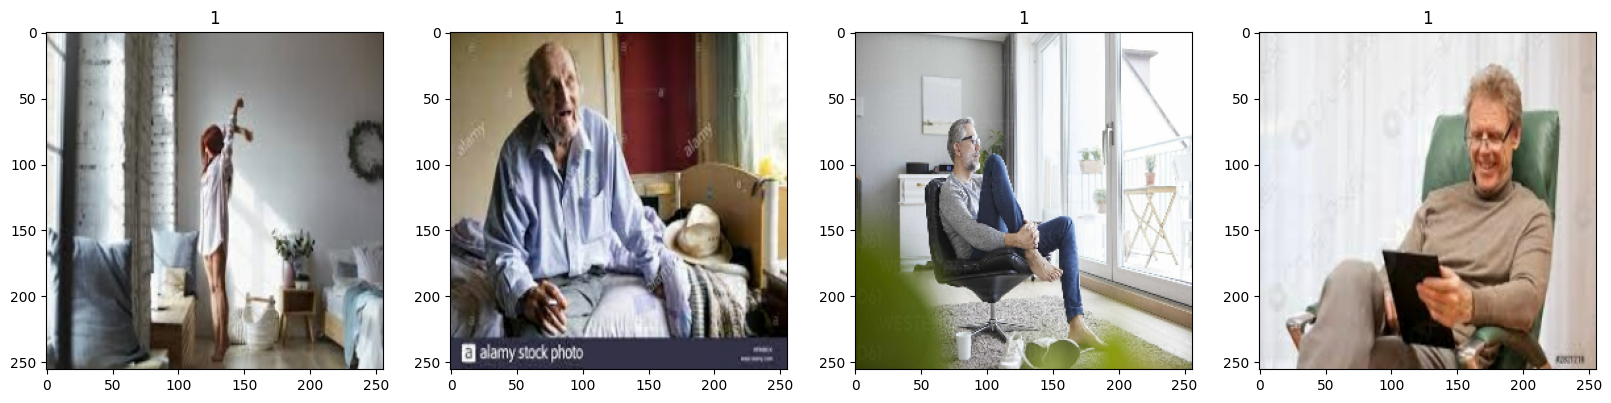

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
#Tensorflow tf dataset map function is used. data.map actually allows you to perform that transformation in pipeline
#x as images and y as labels
#Divide image value to save time in deep learning
#We can't run this for each batch of data pipline, so we have to create another one to scale data
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.49803922, 0.30980393, 0.16078432],
          [0.49803922, 0.30980393, 0.16078432],
          [0.49803922, 0.30980393, 0.16078432],
          ...,
          [0.6218061 , 0.47313112, 0.38155636],
          [0.6272442 , 0.48565412, 0.39174327],
          [0.6929458 , 0.5556219 , 0.46920955]],
 
         [[0.4956342 , 0.3073989 , 0.15837929],
          [0.4956342 , 0.3073989 , 0.15837929],
          [0.4956342 , 0.3073989 , 0.15837929],
          ...,
          [0.57589924, 0.42899516, 0.3278003 ],
          [0.5906615 , 0.44692007, 0.3456673 ],
          [0.6403312 , 0.5006023 , 0.4046121 ]],
 
         [[0.49411765, 0.30309436, 0.15546875],
          [0.49411765, 0.30309436, 0.15546875],
          [0.49411765, 0.30309436, 0.15546875],
          ...,
          [0.5129593 , 0.36299   , 0.24469952],
          [0.5287821 , 0.3795021 , 0.26246777],
          [0.5681219 , 0.42406404, 0.30814338]],
 
         ...,
 
         [[0.44109222, 0.44109222, 0.4332491 ],
          [0.98493

# 5. Split Data

In [17]:
#Split Data into Training and Testing Partition. Validating our data and ensuring that model hasn't overfit
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) #Post Training Deep Learning Model

In [18]:
train_size

8

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


8/8 [==============================] - 6s 586ms/step - loss: 0.8330 - accuracy: 0.4492 - val_loss: 0.6821 - val_accuracy: 0.7969
Epoch 2/20
8/8 [==============================] - 5s 552ms/step - loss: 0.6824 - accuracy: 0.6289 - val_loss: 0.6601 - val_accuracy: 0.6875
Epoch 3/20
8/8 [==============================] - 5s 593ms/step - loss: 0.5978 - accuracy: 0.7773 - val_loss: 0.4887 - val_accuracy: 0.8438
Epoch 4/20
8/8 [==============================] - 6s 609ms/step - loss: 0.5299 - accuracy: 0.7344 - val_loss: 0.4715 - val_accuracy: 0.8906
Epoch 5/20
8/8 [==============================] - 5s 628ms/step - loss: 0.4596 - accuracy: 0.8320 - val_loss: 0.4820 - val_accuracy: 0.7812
Epoch 6/20
8/8 [==============================] - 5s 642ms/step - loss: 0.3968 - accuracy: 0.7812 - val_loss: 0.4075 - val_accuracy: 0.8750
Epoch 7/20
8/8 [==============================] - 6s 650ms/step - loss: 0.3123 - accuracy: 0.8906 - val_loss: 0.2615 - val_accuracy: 0.8594
Epoch 8/20
8/8 [===============

# 8. Plot Performance

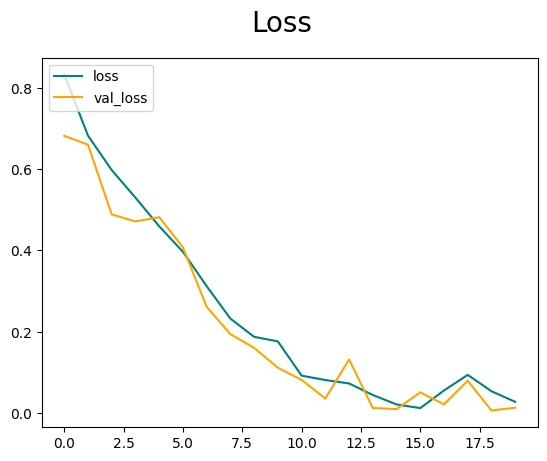

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

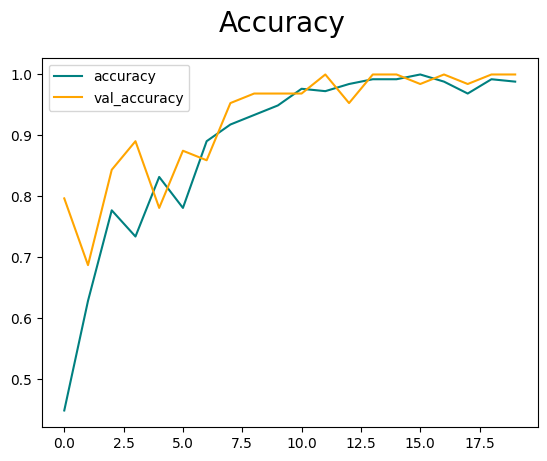

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 194ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

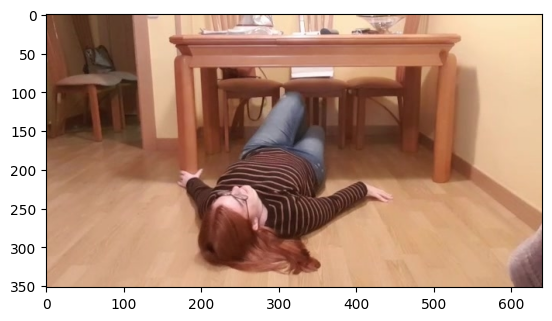

In [36]:
#Testing data outside of the dataset. To test out the image that model has never seen before.

img=cv2.imread('2.jpg') #input random image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #opencv always read image in BGR.
plt.show()

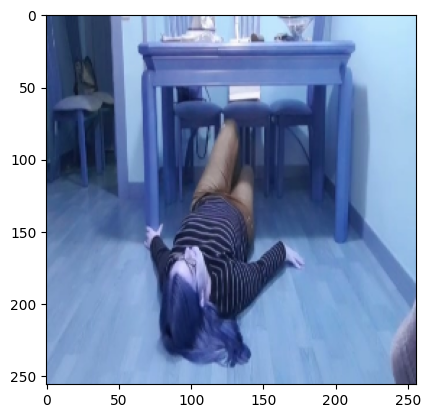

In [37]:
#When we pass data into neural network, the image need to be in shape (256,256) pixels also need to be 3 channel

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
#The reason why we are doing this prediction is, neural network expects us to pass through a batch of images not a single image, so need to encapsulate
#inside of another set of parentheses or array
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 71ms/step


In [39]:
yhat

array([[0.9990692]], dtype=float32)

In [40]:
if yhat > 0.5: 
    print(f'Predicted class is Fall')
else:
    print(f'Predicted class is Not Fall')

Predicted class is Fall


# 11. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('models','imageclassifierforFallorNotFall.h5'))

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
new_model = load_model(os.path.join('models','imageclassifierforFallorNotFall.h5'))

In [44]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 70ms/step


array([[0.9990692]], dtype=float32)